# Species Aggregation Strategy

**Goal:** Reduce ~1700 PERCH-predicted species to the 3 actual aviary species

**Known Aviary Species:**
- Black-headed weaver (*Ploceus melanocephalus*) - 5 individuals
- Eurasian hoopoe (*Upupa epops*) - 2 individuals  
- Red-billed quelea (*Quelea quelea*) - 61 individuals

**Challenge:** PERCH predictions may be unreliable but still contain useful information

**Key Insight from Analysis:** 
PERCH likely misclassified birds within the same genus/family. Since we have only ONE species per genus in the aviary, we can confidently aggregate ALL predictions from each genus to the single target species.

**Analysis Strategy:**
1. **Setup and Load Data** - Import metadata and define target species
2. **Direct Matching** - Find clips already correctly identified
3. **Taxonomic Proximity** - Analyze genus and family relationships
4. **Deep Dive: Genus-Level Aggregation** - Detailed analysis of each target genus:
   - Ploceus (weavers) → Aggregate to *P. melanocephalus*
   - Upupa (hoopoes) → Aggregate to *U. epops*
   - Quelea (queleas) → Aggregate to *Q. quelea*
5. **Final Recommendations** - Summary and next steps
6. **Remaining Clips** - What to do with non-target genera

## 1. Setup and Load Data

In [68]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

# Define paths
BASE_DIR = Path(r"C:\Users\Casper\Documents\GitHub\zoo-acoustics")
DATA_DIR = BASE_DIR / "data" / "fl_gaia_zoo_congo_15aug25_data"
METADATA_FILE = DATA_DIR / "fl_gaia_zoo_congo_15aug25_data_metadata_with_perch.xlsx"
    
# Define target species
TARGET_SPECIES = {
    'Ploceus melanocephalus': 'Black-headed weaver',
    'Upupa epops': 'Eurasian hoopoe',
    'Quelea quelea': 'Red-billed quelea'
}

print("Loading metadata...")
df = pd.read_excel(METADATA_FILE)
print(f"✓ Loaded {len(df):,} audio clips")
print(f"✓ Unique predicted species: {df['scientific_name'].nunique():,}")
print(f"\nColumns: {list(df.columns)}")

Loading metadata...
✓ Loaded 78,837 audio clips
✓ Unique predicted species: 1,759

Columns: ['Unnamed: 0', 'sessionId', 'time', 'filename', 'th1', 'th1_value', 'th2', 'th2_value', 'th3', 'th3_value', 'wudate', 'datetime', 'precipRate', 'pressureMax', 'dewptAvg', 'windgustHigh', 'windspeedAvg', 'tempAve', 'humidityAvg', 'winddirAvg', 'uvHigh', 'solarRadiationHigh', 'lon', 'lat', 'scientific_name', 'code', 'score']


## 2. Direct Matching Analysis

First, let's see how many clips are already correctly identified as one of our 3 target species.

In [69]:
print("="*70)
print("DIRECT MATCH ANALYSIS")
print("="*70)

# Count direct matches
for species_sci, species_common in TARGET_SPECIES.items():
    count = (df['scientific_name'] == species_sci).sum()
    pct = (count / len(df)) * 100
    print(f"\n{species_common} ({species_sci}):")
    print(f"  Direct matches: {count:,} ({pct:.2f}%)")
    
    if count > 0 and 'score' in df.columns:
        species_data = df[df['scientific_name'] == species_sci]
        print(f"  Avg confidence: {species_data['score'].mean():.3f}")
        print(f"  Score range: {species_data['score'].min():.3f} - {species_data['score'].max():.3f}")

# Calculate coverage
direct_matches = df['scientific_name'].isin(TARGET_SPECIES.keys())
total_matched = direct_matches.sum()
total_unmatched = (~direct_matches).sum()

print(f"\n{'='*70}")
print(f"SUMMARY:")
print(f"  Total clips with direct match: {total_matched:,} ({total_matched/len(df)*100:.2f}%)")
print(f"  Total clips to reassign: {total_unmatched:,} ({total_unmatched/len(df)*100:.2f}%)")
print(f"  Unique 'other' species: {df[~direct_matches]['scientific_name'].nunique():,}")

DIRECT MATCH ANALYSIS

Black-headed weaver (Ploceus melanocephalus):
  Direct matches: 2,500 (3.17%)
  Avg confidence: 0.248
  Score range: 0.008 - 0.996

Eurasian hoopoe (Upupa epops):
  Direct matches: 7 (0.01%)
  Avg confidence: 0.301
  Score range: 0.114 - 0.673

Red-billed quelea (Quelea quelea):
  Direct matches: 29 (0.04%)
  Avg confidence: 0.106
  Score range: 0.025 - 0.293

SUMMARY:
  Total clips with direct match: 2,536 (3.22%)
  Total clips to reassign: 76,301 (96.78%)
  Unique 'other' species: 1,756


## 3. Taxonomic Proximity Analysis

Many misidentifications might be taxonomically related species. Let's explore genus and family relationships.

In [70]:
# Extract genus from scientific name (first word)
df['genus'] = df['scientific_name'].str.split().str[0]

# Target genera
target_genera = {
    'Ploceus': 'Black-headed weaver genus (weavers)',
    'Upupa': 'Eurasian hoopoe genus (hoopoes)',
    'Quelea': 'Red-billed quelea genus (queleas)'
}

print("="*70)
print("GENUS-LEVEL ANALYSIS")
print("="*70)

for genus, description in target_genera.items():
    genus_matches = df[df['genus'] == genus]
    count = len(genus_matches)
    pct = (count / len(df)) * 100
    
    print(f"\n{genus} ({description}):")
    print(f"  Total clips: {count:,} ({pct:.2f}%)")
    
    if count > 0:
        species_in_genus = genus_matches['scientific_name'].value_counts()
        print(f"  Unique species in genus: {len(species_in_genus)}")
        print(f"  Species breakdown:")
        for species, sp_count in species_in_genus.items():
            print(f"    - {species}: {sp_count:,}")
        
        if 'score' in df.columns:
            print(f"  Avg confidence: {genus_matches['score'].mean():.3f}")

GENUS-LEVEL ANALYSIS

Ploceus (Black-headed weaver genus (weavers)):
  Total clips: 3,558 (4.51%)
  Unique species in genus: 21
  Species breakdown:
    - Ploceus melanocephalus: 2,500
    - Ploceus galbula: 328
    - Ploceus bojeri: 251
    - Ploceus luteolus: 188
    - Ploceus cucullatus: 107
    - Ploceus velatus: 51
    - Ploceus subaureus: 46
    - Ploceus philippinus: 19
    - Ploceus aurantius: 10
    - Ploceus vitellinus: 8
    - Ploceus xanthops: 8
    - Ploceus taeniopterus: 8
    - Ploceus capensis: 8
    - Ploceus nigerrimus: 7
    - Ploceus jacksoni: 4
    - Ploceus burnieri: 4
    - Ploceus nelicourvi: 4
    - Ploceus princeps: 2
    - Ploceus nigricollis: 2
    - Ploceus pelzelni: 2
    - Ploceus xanthopterus: 1
  Avg confidence: 0.218

Upupa (Eurasian hoopoe genus (hoopoes)):
  Total clips: 10 (0.01%)
  Unique species in genus: 2
  Species breakdown:
    - Upupa epops: 7
    - Upupa marginata: 3
  Avg confidence: 0.275

Quelea (Red-billed quelea genus (queleas)):
  Tota

## 4. Deep Dive: Genus-Level Aggregation Analysis

**From Part 3 Conclusion:** We see that PERCH may have misclassified birds within the same family/genus. For example, multiple Ploceus species are detected, but they're likely all the same Black-headed weaver.

**New Strategy:** For each target genus, analyze ALL species detected within that genus to determine if we can confidently aggregate them to our single target species.

**Analysis Plan:**
1. **Ploceus genus** - Aggregate to *Ploceus melanocephalus* (Black-headed weaver)
2. **Upupa genus** - Aggregate to *Upupa epops* (Eurasian hoopoe)
3. **Quelea genus** - Aggregate to *Quelea quelea* (Red-billed quelea)

For each genus, we'll examine:
- Number of different species detected
- Confidence scores distribution
- Geographic/taxonomic plausibility
- Temporal patterns (do they appear at same times?)
- Total clips that could be aggregated

### 4.1 Ploceus Genus Analysis (Weavers)

In [71]:
print("="*80)
print("PLOCEUS GENUS (WEAVERS) - DETAILED ANALYSIS")
print("="*80)

# Filter all Ploceus species
ploceus_df = df[df['genus'] == 'Ploceus'].copy()

print(f"\nTotal Ploceus clips: {len(ploceus_df):,}")
print(f"Percentage of all clips: {len(ploceus_df)/len(df)*100:.2f}%")

# Get all species in Ploceus genus
ploceus_species = ploceus_df['scientific_name'].value_counts().reset_index()
ploceus_species.columns = ['Species', 'Count']
ploceus_species['Percentage'] = (ploceus_species['Count'] / len(ploceus_df) * 100).round(2)

# Add confidence score stats
if 'score' in df.columns:
    ploceus_species['Avg_Score'] = ploceus_species['Species'].apply(
        lambda x: ploceus_df[ploceus_df['scientific_name'] == x]['score'].mean()
    ).round(3)
    ploceus_species['Min_Score'] = ploceus_species['Species'].apply(
        lambda x: ploceus_df[ploceus_df['scientific_name'] == x]['score'].min()
    ).round(3)
    ploceus_species['Max_Score'] = ploceus_species['Species'].apply(
        lambda x: ploceus_df[ploceus_df['scientific_name'] == x]['score'].max()
    ).round(3)

print(f"\nUnique Ploceus species detected: {len(ploceus_species)}")
print("\n" + "="*80)
print("ALL PLOCEUS SPECIES:")
print("="*80)
print(ploceus_species.to_string(index=False))

# Highlight target species
target_ploceus = ploceus_species[ploceus_species['Species'] == 'Ploceus melanocephalus']
if len(target_ploceus) > 0:
    print("\n" + "="*80)
    print("TARGET SPECIES (Ploceus melanocephalus - Black-headed weaver):")
    print("="*80)
    print(target_ploceus.to_string(index=False))
else:
    print("\n⚠️  WARNING: Target species 'Ploceus melanocephalus' not found in predictions!")

# Analyze other Ploceus species (potential misclassifications)
other_ploceus = ploceus_species[ploceus_species['Species'] != 'Ploceus melanocephalus']
print(f"\n" + "="*80)
print(f"OTHER PLOCEUS SPECIES (Potential misclassifications): {len(other_ploceus)}")
print("="*80)
if len(other_ploceus) > 0:
    print(other_ploceus.to_string(index=False))
    total_other = other_ploceus['Count'].sum()
    print(f"\nTotal clips from other Ploceus species: {total_other:,}")
    print(f"Average confidence of other species: {other_ploceus['Avg_Score'].mean():.3f}")
else:
    print("No other Ploceus species found.")

PLOCEUS GENUS (WEAVERS) - DETAILED ANALYSIS

Total Ploceus clips: 3,558
Percentage of all clips: 4.51%

Unique Ploceus species detected: 21

ALL PLOCEUS SPECIES:
               Species  Count  Percentage  Avg_Score  Min_Score  Max_Score
Ploceus melanocephalus   2500       70.26      0.248      0.008      0.996
       Ploceus galbula    328        9.22      0.159      0.006      0.854
        Ploceus bojeri    251        7.05      0.209      0.017      0.837
      Ploceus luteolus    188        5.28      0.086      0.004      0.376
    Ploceus cucullatus    107        3.01      0.136      0.007      0.622
       Ploceus velatus     51        1.43      0.123      0.010      0.461
     Ploceus subaureus     46        1.29      0.104      0.020      0.467
   Ploceus philippinus     19        0.53      0.104      0.014      0.489
     Ploceus aurantius     10        0.28      0.038      0.015      0.062
    Ploceus vitellinus      8        0.22      0.070      0.035      0.100
      Ploceus

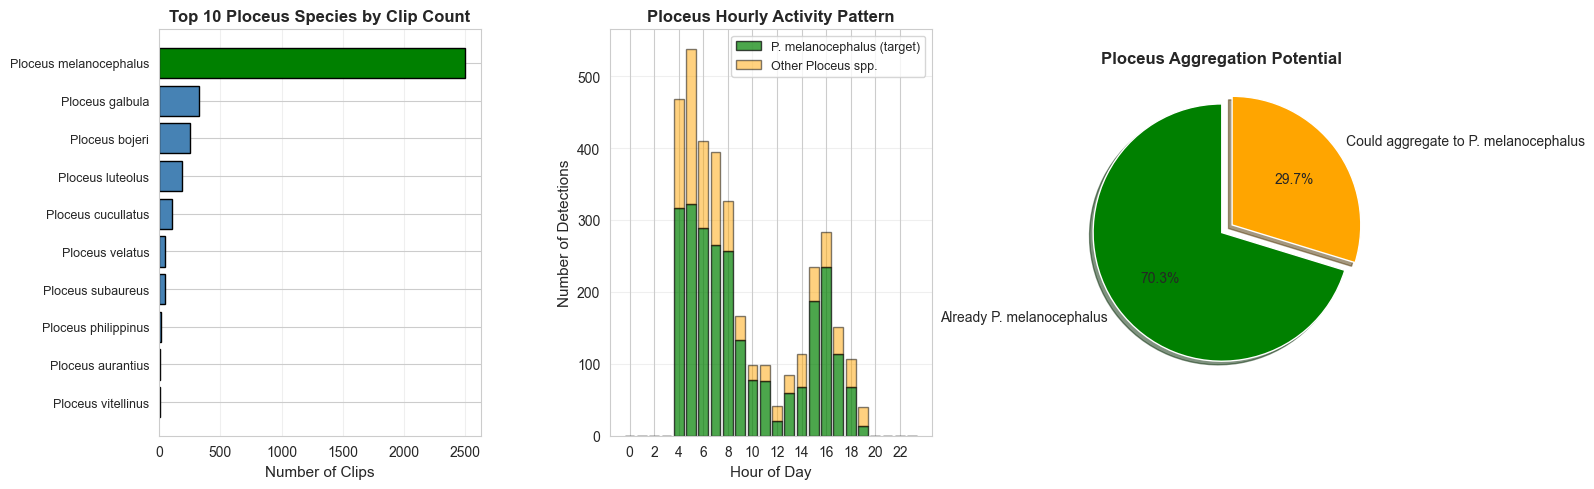

✓ Total Ploceus clips: 3,558
✓ Already labeled as P. melanocephalus: 2,500 (70.3%)
✓ Could aggregate from other Ploceus species: 1,058 (29.7%)


In [72]:
# Visualize Ploceus species distribution
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Species count bar chart
top_ploceus = ploceus_species.head(10)
colors_bar = ['green' if sp == 'Ploceus melanocephalus' else 'steelblue' 
              for sp in top_ploceus['Species']]

axes[0].barh(range(len(top_ploceus)), top_ploceus['Count'], color=colors_bar, edgecolor='black')
axes[0].set_yticks(range(len(top_ploceus)))
axes[0].set_yticklabels(top_ploceus['Species'], fontsize=9)
axes[0].set_xlabel('Number of Clips', fontsize=11)
axes[0].set_title('Top 10 Ploceus Species by Clip Count', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# 2. Temporal distribution if datetime available
if 'datetime' in df.columns:
    ploceus_df['datetime_parsed'] = pd.to_datetime(ploceus_df['datetime'], errors='coerce')
    ploceus_df['hour'] = ploceus_df['datetime_parsed'].dt.hour
    
    # Compare target vs other Ploceus hourly patterns
    target_hours = ploceus_df[ploceus_df['scientific_name'] == 'Ploceus melanocephalus']['hour'].value_counts().sort_index()
    other_hours = ploceus_df[ploceus_df['scientific_name'] != 'Ploceus melanocephalus']['hour'].value_counts().sort_index()
    
    hours_range = range(24)
    target_counts = [target_hours.get(h, 0) for h in hours_range]
    other_counts = [other_hours.get(h, 0) for h in hours_range]
    
    axes[1].bar(hours_range, target_counts, alpha=0.7, label='P. melanocephalus (target)', 
                   color='green', edgecolor='black')
    axes[1].bar(hours_range, other_counts, alpha=0.5, label='Other Ploceus spp.', 
                   color='orange', edgecolor='black', bottom=target_counts)
    axes[1].set_xlabel('Hour of Day', fontsize=11)
    axes[1].set_ylabel('Number of Detections', fontsize=11)
    axes[1].set_title('Ploceus Hourly Activity Pattern', fontsize=12, fontweight='bold')
    axes[1].legend(fontsize=9)
    axes[1].set_xticks(range(0, 24, 2))
    axes[1].grid(axis='y', alpha=0.3)

# 3. Pie chart of aggregation potential
if len(other_ploceus) > 0:
    target_count = ploceus_species[ploceus_species['Species'] == 'Ploceus melanocephalus']['Count'].sum()
    other_count = other_ploceus['Count'].sum()
    
    sizes = [target_count, other_count]
    labels_pie = ['Already P. melanocephalus', 'Could aggregate to P. melanocephalus']
    colors_pie = ['green', 'orange']
    explode = (0, 0.1)
    
    axes[2].pie(sizes, explode=explode, labels=labels_pie, colors=colors_pie,
                   autopct='%1.1f%%', shadow=True, startangle=90)
    axes[2].set_title('Ploceus Aggregation Potential', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

total_ploceus = len(ploceus_df)
if len(target_ploceus) > 0:
    already_correct = target_ploceus['Count'].values[0]
else:
    already_correct = 0
could_aggregate = total_ploceus - already_correct

print(f"✓ Total Ploceus clips: {total_ploceus:,}")
print(f"✓ Already labeled as P. melanocephalus: {already_correct:,} ({already_correct/total_ploceus*100:.1f}%)")
print(f"✓ Could aggregate from other Ploceus species: {could_aggregate:,} ({could_aggregate/total_ploceus*100:.1f}%)")

### 4.2 Upupa Genus Analysis (Hoopoes)

In [73]:
print("="*80)
print("UPUPA GENUS (HOOPOES) - DETAILED ANALYSIS")
print("="*80)

# Filter all Upupa species
upupa_df = df[df['genus'] == 'Upupa'].copy()

print(f"\nTotal Upupa clips: {len(upupa_df):,}")
print(f"Percentage of all clips: {len(upupa_df)/len(df)*100:.2f}%")

# Get all species in Upupa genus
upupa_species = upupa_df['scientific_name'].value_counts().reset_index()
upupa_species.columns = ['Species', 'Count']
upupa_species['Percentage'] = (upupa_species['Count'] / len(upupa_df) * 100).round(2)

# Add confidence score stats
if 'score' in df.columns:
    upupa_species['Avg_Score'] = upupa_species['Species'].apply(
        lambda x: upupa_df[upupa_df['scientific_name'] == x]['score'].mean()
    ).round(3)
    upupa_species['Min_Score'] = upupa_species['Species'].apply(
        lambda x: upupa_df[upupa_df['scientific_name'] == x]['score'].min()
    ).round(3)
    upupa_species['Max_Score'] = upupa_species['Species'].apply(
        lambda x: upupa_df[upupa_df['scientific_name'] == x]['score'].max()
    ).round(3)

print(f"\nUnique Upupa species detected: {len(upupa_species)}")
print("\n" + "="*80)
print("ALL UPUPA SPECIES:")
print("="*80)
print(upupa_species.to_string(index=False))

# Highlight target species
target_upupa = upupa_species[upupa_species['Species'] == 'Upupa epops']
if len(target_upupa) > 0:
    print("\n" + "="*80)
    print("TARGET SPECIES (Upupa epops - Eurasian hoopoe):")
    print("="*80)
    print(target_upupa.to_string(index=False))
else:
    print("\n⚠️  WARNING: Target species 'Upupa epops' not found in predictions!")

# Analyze other Upupa species (potential misclassifications)
other_upupa = upupa_species[upupa_species['Species'] != 'Upupa epops']
print(f"\n" + "="*80)
print(f"OTHER UPUPA SPECIES (Potential misclassifications): {len(other_upupa)}")
print("="*80)
if len(other_upupa) > 0:
    print(other_upupa.to_string(index=False))
    total_other = other_upupa['Count'].sum()
    print(f"\nTotal clips from other Upupa species: {total_other:,}")
    print(f"Average confidence of other species: {other_upupa['Avg_Score'].mean():.3f}")
else:
    print("No other Upupa species found.")

UPUPA GENUS (HOOPOES) - DETAILED ANALYSIS

Total Upupa clips: 10
Percentage of all clips: 0.01%

Unique Upupa species detected: 2

ALL UPUPA SPECIES:
        Species  Count  Percentage  Avg_Score  Min_Score  Max_Score
    Upupa epops      7        70.0      0.301      0.114      0.673
Upupa marginata      3        30.0      0.214      0.180      0.283

TARGET SPECIES (Upupa epops - Eurasian hoopoe):
    Species  Count  Percentage  Avg_Score  Min_Score  Max_Score
Upupa epops      7        70.0      0.301      0.114      0.673

OTHER UPUPA SPECIES (Potential misclassifications): 1
        Species  Count  Percentage  Avg_Score  Min_Score  Max_Score
Upupa marginata      3        30.0      0.214       0.18      0.283

Total clips from other Upupa species: 3
Average confidence of other species: 0.214


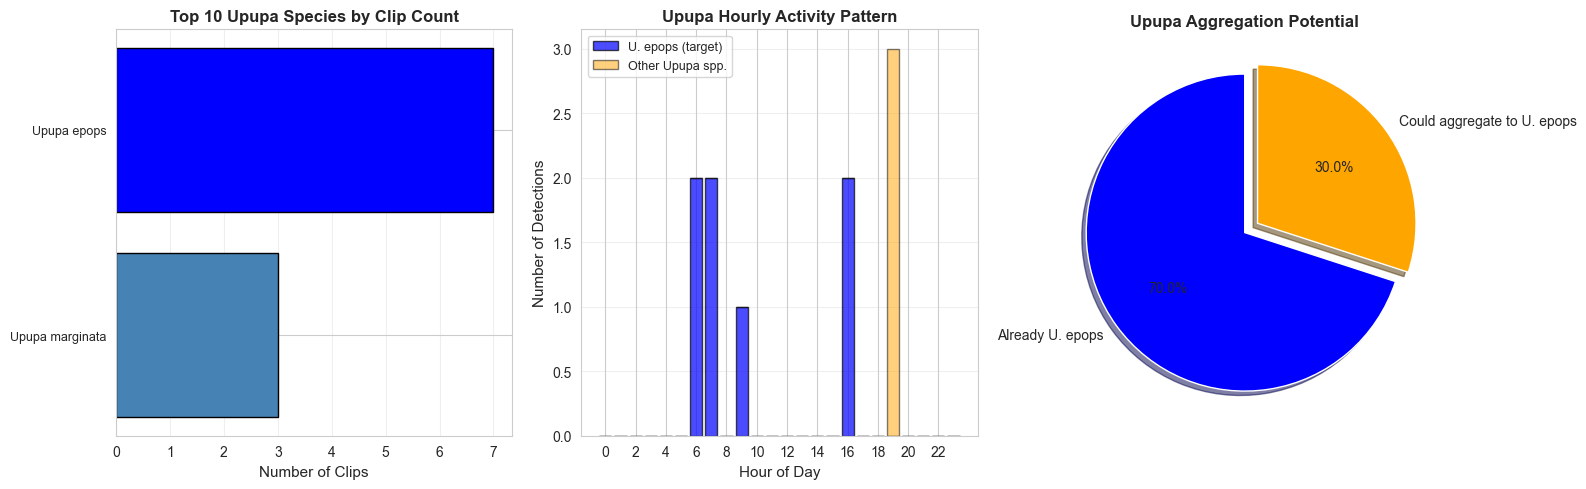

✓ Total Upupa clips: 10
✓ Already labeled as U. epops: 7 (70.0%)
✓ Could aggregate from other Upupa species: 3 (30.0%)


In [74]:
# Visualize Upupa species distribution
if len(upupa_df) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # 1. Species count bar chart
    top_upupa = upupa_species.head(10)
    colors_bar = ['blue' if sp == 'Upupa epops' else 'steelblue' 
                  for sp in top_upupa['Species']]
    
    axes[0].barh(range(len(top_upupa)), top_upupa['Count'], color=colors_bar, edgecolor='black')
    axes[0].set_yticks(range(len(top_upupa)))
    axes[0].set_yticklabels(top_upupa['Species'], fontsize=9)
    axes[0].set_xlabel('Number of Clips', fontsize=11)
    axes[0].set_title('Top 10 Upupa Species by Clip Count', fontsize=12, fontweight='bold')
    axes[0].invert_yaxis()
    axes[0].grid(axis='x', alpha=0.3)

    # 2. Temporal distribution if datetime available
    if 'datetime' in df.columns:
        upupa_df['datetime_parsed'] = pd.to_datetime(upupa_df['datetime'], errors='coerce')
        upupa_df['hour'] = upupa_df['datetime_parsed'].dt.hour
        
        # Compare target vs other Upupa hourly patterns
        target_hours = upupa_df[upupa_df['scientific_name'] == 'Upupa epops']['hour'].value_counts().sort_index()
        other_hours = upupa_df[upupa_df['scientific_name'] != 'Upupa epops']['hour'].value_counts().sort_index()
        
        hours_range = range(24)
        target_counts = [target_hours.get(h, 0) for h in hours_range]
        other_counts = [other_hours.get(h, 0) for h in hours_range]
        
        axes[1].bar(hours_range, target_counts, alpha=0.7, label='U. epops (target)', 
                       color='blue', edgecolor='black')
        axes[1].bar(hours_range, other_counts, alpha=0.5, label='Other Upupa spp.', 
                       color='orange', edgecolor='black', bottom=target_counts)
        axes[1].set_xlabel('Hour of Day', fontsize=11)
        axes[1].set_ylabel('Number of Detections', fontsize=11)
        axes[1].set_title('Upupa Hourly Activity Pattern', fontsize=12, fontweight='bold')
        axes[1].legend(fontsize=9)
        axes[1].set_xticks(range(0, 24, 2))
        axes[1].grid(axis='y', alpha=0.3)

    # 3. Pie chart of aggregation potential
    if len(other_upupa) > 0:
        target_count = upupa_species[upupa_species['Species'] == 'Upupa epops']['Count'].sum()
        other_count = other_upupa['Count'].sum()
        
        sizes = [target_count, other_count]
        labels_pie = ['Already U. epops', 'Could aggregate to U. epops']
        colors_pie = ['blue', 'orange']
        explode = (0, 0.1)
        
        axes[2].pie(sizes, explode=explode, labels=labels_pie, colors=colors_pie,
                       autopct='%1.1f%%', shadow=True, startangle=90)
        axes[2].set_title('Upupa Aggregation Potential', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

    total_upupa = len(upupa_df)
    if len(target_upupa) > 0:
        already_correct = target_upupa['Count'].values[0]
    else:
        already_correct = 0
    could_aggregate = total_upupa - already_correct
    
    print(f"✓ Total Upupa clips: {total_upupa:,}")
    print(f"✓ Already labeled as U. epops: {already_correct:,} ({already_correct/total_upupa*100:.1f}%)")
    print(f"✓ Could aggregate from other Upupa species: {could_aggregate:,} ({could_aggregate/total_upupa*100:.1f}%)")
else:
    print("\n⚠️  No Upupa clips found in dataset!")

### 4.3 Quelea Genus Analysis (Queleas)

In [75]:
print("="*80)
print("QUELEA GENUS (QUELEAS) - DETAILED ANALYSIS")
print("="*80)

# Filter all Quelea species
quelea_df = df[df['genus'] == 'Quelea'].copy()

print(f"\nTotal Quelea clips: {len(quelea_df):,}")
print(f"Percentage of all clips: {len(quelea_df)/len(df)*100:.2f}%")

# Get all species in Quelea genus
quelea_species = quelea_df['scientific_name'].value_counts().reset_index()
quelea_species.columns = ['Species', 'Count']
quelea_species['Percentage'] = (quelea_species['Count'] / len(quelea_df) * 100).round(2)

# Add confidence score stats
if 'score' in df.columns:
    quelea_species['Avg_Score'] = quelea_species['Species'].apply(
        lambda x: quelea_df[quelea_df['scientific_name'] == x]['score'].mean()
    ).round(3)
    quelea_species['Min_Score'] = quelea_species['Species'].apply(
        lambda x: quelea_df[quelea_df['scientific_name'] == x]['score'].min()
    ).round(3)
    quelea_species['Max_Score'] = quelea_species['Species'].apply(
        lambda x: quelea_df[quelea_df['scientific_name'] == x]['score'].max()
    ).round(3)

print(f"\nUnique Quelea species detected: {len(quelea_species)}")
print("\n" + "="*80)
print("ALL QUELEA SPECIES:")
print("="*80)
print(quelea_species.to_string(index=False))

# Highlight target species
target_quelea = quelea_species[quelea_species['Species'] == 'Quelea quelea']
if len(target_quelea) > 0:
    print("\n" + "="*80)
    print("TARGET SPECIES (Quelea quelea - Red-billed quelea):")
    print("="*80)
    print(target_quelea.to_string(index=False))
else:
    print("\n⚠️  WARNING: Target species 'Quelea quelea' not found in predictions!")

# Analyze other Quelea species (potential misclassifications)
other_quelea = quelea_species[quelea_species['Species'] != 'Quelea quelea']
print(f"\n" + "="*80)
print(f"OTHER QUELEA SPECIES (Potential misclassifications): {len(other_quelea)}")
print("="*80)
if len(other_quelea) > 0:
    print(other_quelea.to_string(index=False))
    total_other = other_quelea['Count'].sum()
    print(f"\nTotal clips from other Quelea species: {total_other:,}")
    print(f"Average confidence of other species: {other_quelea['Avg_Score'].mean():.3f}")
else:
    print("No other Quelea species found.")

QUELEA GENUS (QUELEAS) - DETAILED ANALYSIS

Total Quelea clips: 29
Percentage of all clips: 0.04%

Unique Quelea species detected: 1

ALL QUELEA SPECIES:
      Species  Count  Percentage  Avg_Score  Min_Score  Max_Score
Quelea quelea     29       100.0      0.106      0.025      0.293

TARGET SPECIES (Quelea quelea - Red-billed quelea):
      Species  Count  Percentage  Avg_Score  Min_Score  Max_Score
Quelea quelea     29       100.0      0.106      0.025      0.293

OTHER QUELEA SPECIES (Potential misclassifications): 0
No other Quelea species found.


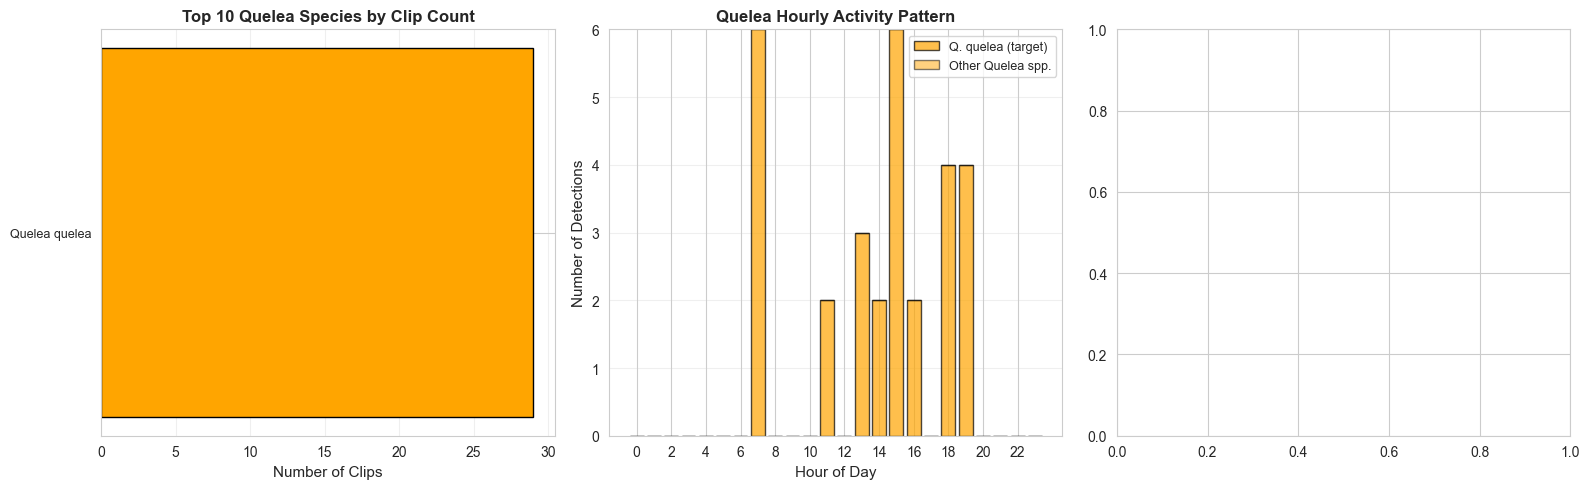

✓ Total Quelea clips: 29
✓ Already labeled as Q. quelea: 29 (100.0%)
✓ Could aggregate from other Quelea species: 0 (0.0%)


In [76]:
# Visualize Quelea species distribution
if len(quelea_df) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # 1. Species count bar chart
    top_quelea = quelea_species.head(10)
    colors_bar = ['orange' if sp == 'Quelea quelea' else 'steelblue' 
                  for sp in top_quelea['Species']]
    
    axes[0].barh(range(len(top_quelea)), top_quelea['Count'], color=colors_bar, edgecolor='black')
    axes[0].set_yticks(range(len(top_quelea)))
    axes[0].set_yticklabels(top_quelea['Species'], fontsize=9)
    axes[0].set_xlabel('Number of Clips', fontsize=11)
    axes[0].set_title('Top 10 Quelea Species by Clip Count', fontsize=12, fontweight='bold')
    axes[0].invert_yaxis()
    axes[0].grid(axis='x', alpha=0.3)
    
    # 2. Temporal distribution if datetime available
    if 'datetime' in df.columns:
        quelea_df['datetime_parsed'] = pd.to_datetime(quelea_df['datetime'], errors='coerce')
        quelea_df['hour'] = quelea_df['datetime_parsed'].dt.hour
        
        # Compare target vs other Quelea hourly patterns
        target_hours = quelea_df[quelea_df['scientific_name'] == 'Quelea quelea']['hour'].value_counts().sort_index()
        other_hours = quelea_df[quelea_df['scientific_name'] != 'Quelea quelea']['hour'].value_counts().sort_index()
        
        hours_range = range(24)
        target_counts = [target_hours.get(h, 0) for h in hours_range]
        other_counts = [other_hours.get(h, 0) for h in hours_range]
        
        axes[1].bar(hours_range, target_counts, alpha=0.7, label='Q. quelea (target)', 
                       color='orange', edgecolor='black')
        axes[1].bar(hours_range, other_counts, alpha=0.5, label='Other Quelea spp.', 
                       color='orange', edgecolor='black', bottom=target_counts)
        axes[1].set_xlabel('Hour of Day', fontsize=11)
        axes[1].set_ylabel('Number of Detections', fontsize=11)
        axes[1].set_title('Quelea Hourly Activity Pattern', fontsize=12, fontweight='bold')
        axes[1].legend(fontsize=9)
        axes[1].set_xticks(range(0, 24, 2))
        axes[1].grid(axis='y', alpha=0.3)

    # 3. Pie chart of aggregation potential
    if len(other_quelea) > 0:
        target_count = quelea_species[quelea_species['Species'] == 'Quelea quelea']['Count'].sum()
        other_count = other_quelea['Count'].sum()
        
        sizes = [target_count, other_count]
        labels_pie = ['Already Q. quelea', 'Could aggregate to Q. quelea']
        colors_pie = ['orange', 'red']
        explode = (0, 0.1)
        
        axes[2].pie(sizes, explode=explode, labels=labels_pie, colors=colors_pie,
                       autopct='%1.1f%%', shadow=True, startangle=90)
        axes[2].set_title('Quelea Aggregation Potential', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

    total_quelea = len(quelea_df)
    if len(target_quelea) > 0:
        already_correct = target_quelea['Count'].values[0]
    else:
        already_correct = 0
    could_aggregate = total_quelea - already_correct
    
    print(f"✓ Total Quelea clips: {total_quelea:,}")
    print(f"✓ Already labeled as Q. quelea: {already_correct:,} ({already_correct/total_quelea*100:.1f}%)")
    print(f"✓ Could aggregate from other Quelea species: {could_aggregate:,} ({could_aggregate/total_quelea*100:.1f}%)")
else:
    print("\n⚠️  No Quelea clips found in dataset!")

### 4.4 Cross-Genus Comparison & Family Analysis

CROSS-GENUS COMPARISON & FAMILY ANALYSIS

📊 SUMMARY OF THREE TARGET GENERA:
  Genus         Common Name  Total Clips  % of Dataset  Target Species Clips  Other Species in Genus  Avg Confidence
Ploceus Black-headed weaver         3558      4.513109                  2500                      20        0.218133
  Upupa     Eurasian hoopoe           10      0.012684                     7                       1        0.275061
 Quelea   Red-billed quelea           29      0.036785                    29                       0        0.106219


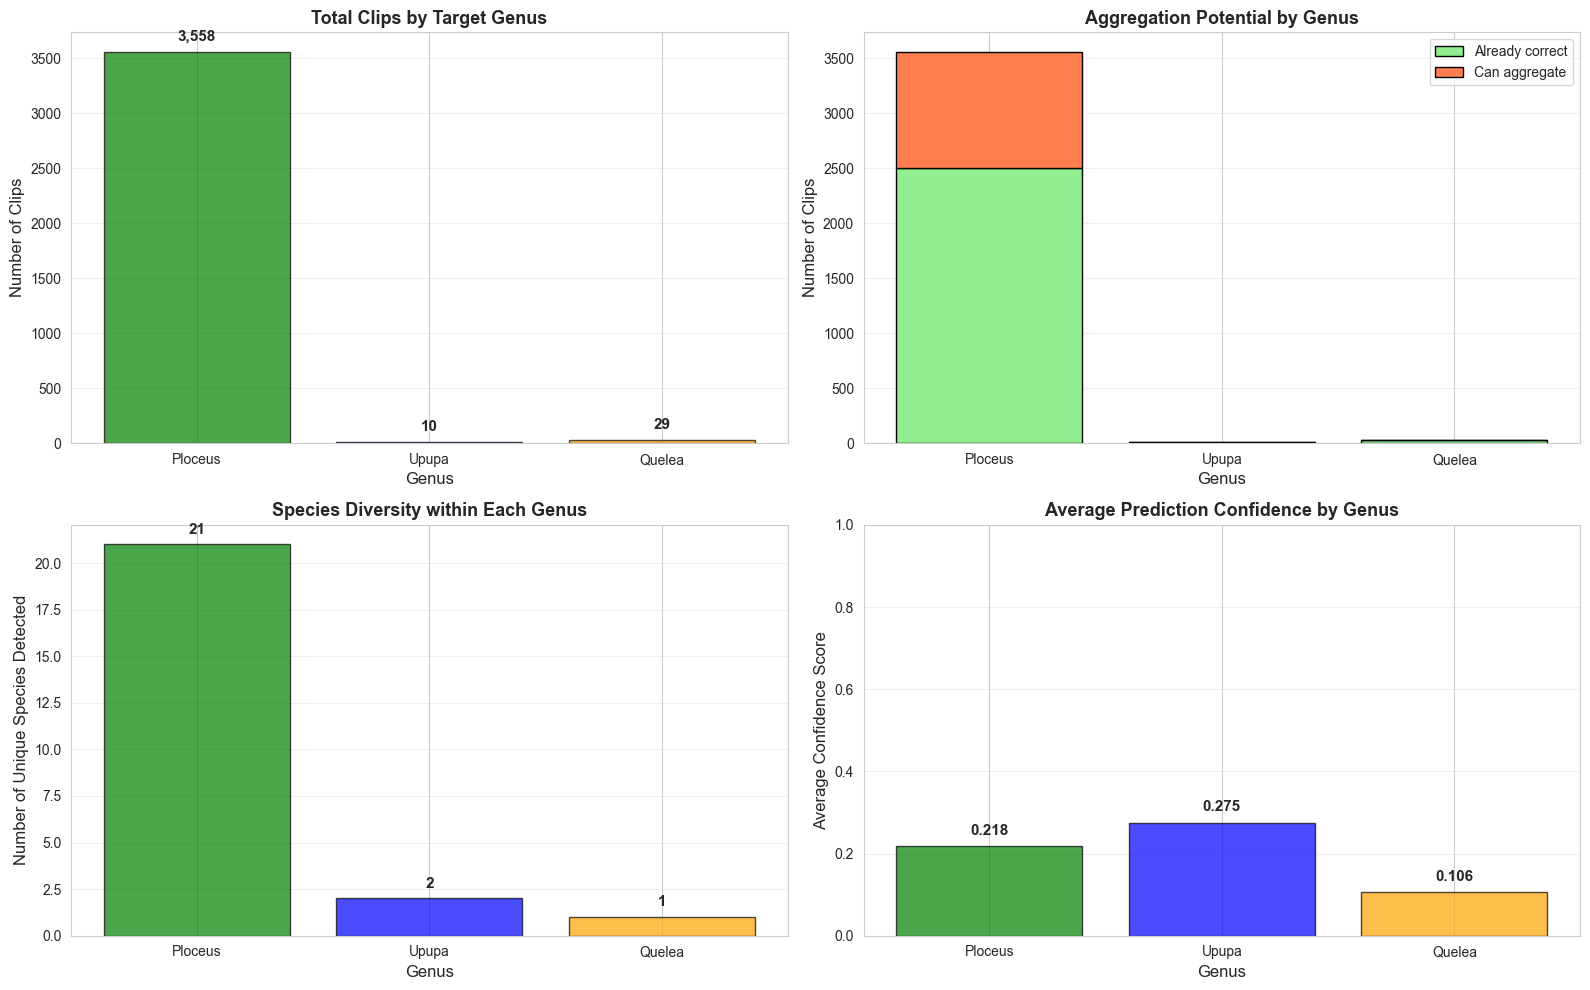

In [77]:
print("="*80)
print("CROSS-GENUS COMPARISON & FAMILY ANALYSIS")
print("="*80)

# Note: Ploceus and Quelea are both in family Ploceidae (weavers)
# Let's check if PERCH confused them with each other

print("\n📊 SUMMARY OF THREE TARGET GENERA:")
print("="*80)

summary_data = []

for genus_name, target_sp, common in [('Ploceus', 'Ploceus melanocephalus', 'Black-headed weaver'),
                                       ('Upupa', 'Upupa epops', 'Eurasian hoopoe'),
                                       ('Quelea', 'Quelea quelea', 'Red-billed quelea')]:
    genus_clips = df[df['genus'] == genus_name]
    total = len(genus_clips)
    pct_dataset = (total / len(df) * 100) if len(df) > 0 else 0
    
    target_clips = genus_clips[genus_clips['scientific_name'] == target_sp]
    target_count = len(target_clips)
    
    unique_species = genus_clips['scientific_name'].nunique()
    
    if 'score' in df.columns and total > 0:
        avg_score = genus_clips['score'].mean()
    else:
        avg_score = 0
    
    summary_data.append({
        'Genus': genus_name,
        'Common Name': common,
        'Total Clips': total,
        '% of Dataset': pct_dataset,
        'Target Species Clips': target_count,
        'Other Species in Genus': unique_species - (1 if target_count > 0 else 0),
        'Avg Confidence': avg_score
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Total clips by genus
genera_names = summary_df['Genus']
total_clips = summary_df['Total Clips']
colors_genus = ['green', 'blue', 'orange']

axes[0, 0].bar(genera_names, total_clips, color=colors_genus, edgecolor='black', alpha=0.7)
axes[0, 0].set_ylabel('Number of Clips', fontsize=12)
axes[0, 0].set_xlabel('Genus', fontsize=12)
axes[0, 0].set_title('Total Clips by Target Genus', fontsize=13, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(total_clips):
    axes[0, 0].text(i, v + max(total_clips)*0.02, f'{v:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 2. Aggregation potential (stacked bar)
target_counts = summary_df['Target Species Clips'].values
aggregatable = total_clips - target_counts

x_pos = np.arange(len(genera_names))
axes[0, 1].bar(x_pos, target_counts, label='Already correct', color='lightgreen', edgecolor='black')
axes[0, 1].bar(x_pos, aggregatable, bottom=target_counts, label='Can aggregate', color='coral', edgecolor='black')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(genera_names)
axes[0, 1].set_ylabel('Number of Clips', fontsize=12)
axes[0, 1].set_xlabel('Genus', fontsize=12)
axes[0, 1].set_title('Aggregation Potential by Genus', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Species diversity in each genus
species_diversity = summary_df['Other Species in Genus'].values + 1  # +1 for target species
axes[1, 0].bar(genera_names, species_diversity, color=colors_genus, edgecolor='black', alpha=0.7)
axes[1, 0].set_ylabel('Number of Unique Species Detected', fontsize=12)
axes[1, 0].set_xlabel('Genus', fontsize=12)
axes[1, 0].set_title('Species Diversity within Each Genus', fontsize=13, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

for i, v in enumerate(species_diversity):
    axes[1, 0].text(i, v + max(species_diversity)*0.02, f'{v}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 4. Average confidence scores
avg_scores = summary_df['Avg Confidence'].values
axes[1, 1].bar(genera_names, avg_scores, color=colors_genus, edgecolor='black', alpha=0.7)
axes[1, 1].set_ylabel('Average Confidence Score', fontsize=12)
axes[1, 1].set_xlabel('Genus', fontsize=12)
axes[1, 1].set_title('Average Prediction Confidence by Genus', fontsize=13, fontweight='bold')
axes[1, 1].set_ylim(0, 1.0)
axes[1, 1].grid(axis='y', alpha=0.3)

for i, v in enumerate(avg_scores):
    axes[1, 1].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()